In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, text

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)

# reflect the tables
Base.classes.keys()

['measurement', 'station']

In [7]:
# View all of the classes that automap found
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Find the columns for the 'measurement' table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Find the columns for the 'station' table
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

recent_date

('2017-08-23',)

In [13]:
# Extract year, month, day from recent_date
recent_year = int(recent_date[0][0:4])
recent_month = int(recent_date[0][5:7])
recent_day = int(recent_date[0][8:10])


In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Most recent date in datetime 
last_date = dt.date(recent_year, recent_month, recent_day)

# Calculate the date one year from the last date in data set.
year_back = last_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp_query = session.query(Measurement.date, 
                           Measurement.prcp).filter(Measurement.date >= year_back).\
                                             order_by(Measurement.date).\
                                             all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_ls_dict = [{"Date": prcp[0], "Precipitation": prcp[1]} for prcp in prcp_query]
prcp_df = pd.DataFrame(prcp_ls_dict)

# Sort the dataframe by date
prcp_df.sort_values(by="Date", inplace=True)

# Convert "Date" column to datetime
prcp_df["Date"] = pd.to_datetime(prcp_df["Date"])


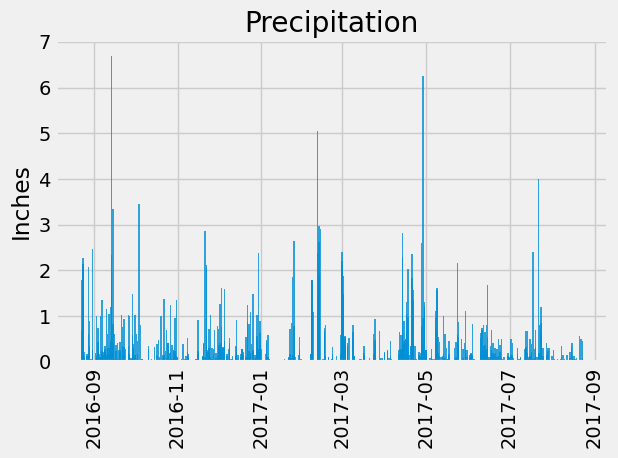

In [15]:
# Plot the last 12 months of Precipitation
plt.bar(data=prcp_df, x="Date", height="Precipitation", alpha=.8, width=1)
plt.title("Precipitation")
plt.ylabel("Inches")
plt.xticks(rotation=90)

plt.tight_layout()

plt.show()

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
display(prcp_df.describe())

,Date,Precipitation
count,2230,2021.000000
mean,2017-02-16 05:31:15.874439424,0.177279
min,2016-08-23 00:00:00,0.000000
25%,2016-11-18 00:00:00,0.000000
50%,2017-02-14 12:00:00,0.020000
75%,2017-05-17 00:00:00,0.130000
max,2017-08-23 00:00:00,6.700000
std,NaN,0.461190


# Exploratory Station Analysis

In [17]:
# Calculate the total number of stations in the dataset
stations = session.query(Station.station).distinct().all()
station_names = session.query(Station.name).distinct().all()
station_count = session.query(Station.station).distinct().count()

station_count

9

In [18]:
station_list = [station[0] for station in station_names]

station_list

['WAIKIKI 717.2, HI US',
 'KANEOHE 838.1, HI US',
 'KUALOA RANCH HEADQUARTERS 886.9, HI US',
 'PEARL CITY, HI US',
 'UPPER WAHIAWA 874.3, HI US',
 'WAIMANALO EXPERIMENTAL FARM, HI US',
 'WAIHEE 837.5, HI US',
 'HONOLULU OBSERVATORY 702.2, HI US',
 'MANOA LYON ARBO 785.2, HI US']

In [19]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_row_count = session.query(Measurement.station, 
                                  func.count(Measurement.station)).\
                                  group_by(Measurement.station).\
                                  order_by(func.count(Measurement.station).desc()).\
                                  all()

station_row_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Convert 1 year prior to DateTime format
year_back = dt.date(2017, 8, 23) - dt.timedelta(days=365)
# Query the activity of each station for the previous 12 months
station_row_count = session.query(Measurement.station, 
                              func.count(Measurement.station)).\
                              filter(Measurement.date >= year_back).\
                              group_by(Measurement.station).\
                              order_by(func.count(Measurement.station).desc()).\
                              all()
# Most active station
top_station = station_row_count[0][0]
# Query and list temps for the top_station
top_station_temps = session.query(Measurement.date, Measurement.tobs).\
                              filter(Measurement.station == top_station).\
                              filter(Measurement.date >= year_back).\
                              all()
# List of dicts containing dates and temps for the previous 12 months
temps_list = [{Date: temp} for Date, temp in top_station_temps]
temps_list = [top_station] + temps_list

# display(temps_list)

In [21]:
# Using the most active station id from the previous query, calculate the lowest, highest, 
# and average temperature.

# top station - most active
top = station_row_count[0][0]

# query columns
sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]

# find min, max, average temp
session.query(*sel).filter(Measurement.station == top).all()



[(56.0, 87.0, 74.55323054331865)]

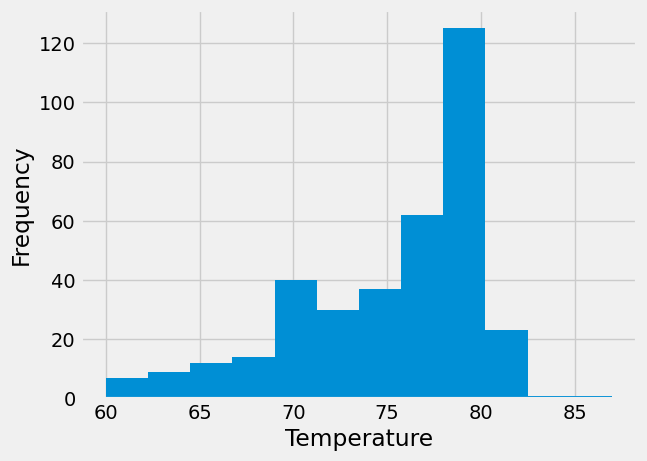

In [22]:
# Using the most active station id
# Query and plot a histogram of the temperature for the last 12 months
sel = [Measurement.tobs]
temps = session.query(*sel).filter(Measurement.date >= year_back).\
                            filter(Measurement.station == top).\
                            all()

# Make a list of dictionaries with temperatures
temps_dict = [{"Temperature": temp[0]} for temp in temps]

# Form DataFrame with temps
temps_df = pd.DataFrame(temps_dict)

# Plot histogram
plt.hist(x=temps_df, bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")

plt.show()

# Close Session

In [23]:
# Close Session
session.close()